In [2]:
# ---------------------------------------------------------------------
# Part 3 — Modeling pipeline
# - load regression-ready dataset
# - z-standardize days_since_upload
# - define X / y and train/test split (70/30)
# - fit OLS (statsmodels) and sklearn LinearRegression
# - compute VIF (multicollinearity)
# - compute SHAP for linear model (works fine)
# - perform RandomizedSearchCV for RF (valid max_features)
# - save models and results
# ---------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap
import joblib   # to save models

sns.set(style="whitegrid")

In [3]:
# -------------------------
# 1) Load dataset
# -------------------------
df = pd.read_csv("tiktok_regression_ready.csv")


In [4]:
# -------------------------
# 2) Standardize days_since_upload (z-score)
# -------------------------
df['days_since_upload_z'] = (df['days_since_upload'] - df['days_since_upload'].mean()) / df['days_since_upload'].std()
print(df['days_since_upload_z'].describe())

count    3.868000e+03
mean    -8.817490e-17
std      1.000000e+00
min     -1.691128e+00
25%     -8.665275e-01
50%     -3.222607e-02
75%      8.505812e-01
max      1.830400e+00
Name: days_since_upload_z, dtype: float64


In [8]:
# -------------------------
# 3) Define features (X) and target (y)
# -------------------------
target = 'M5_view_count_log_z'
y = df[target]
X = df.drop(columns=[target])   # everything else as predictors

# --- Remove raw days_since_upload if present ---
if 'days_since_upload' in X.columns:
    X = X.drop(columns=['days_since_upload'])


In [9]:
# -------------------------
# 4) Train/Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (2707, 41) (1161, 41) (2707,) (1161,)


In [10]:
# -------------------------
# 5) Quick VIF check (multicollinearity)
# -------------------------
# Compute VIFs on training set (needs numeric matrix without constant)
X_train_for_vif = X_train.copy()
# Add constant for VIF? not necessary; we compute on features only
vif_df = pd.DataFrame()
vif_df["feature"] = X_train_for_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_train_for_vif.values, i) for i in range(X_train_for_vif.shape[1])]
print("\nVIF (training set):\n", vif_df.sort_values("VIF", ascending=False).head(20))

# If VIF values >> 10 for many features, consider removing collinear dummies or use Ridge.


VIF (training set):
                               feature        VIF
16                           V7b_text  27.354952
29                     newsformat_2.0  22.463489
11            V4_country_of_origin_CH  14.118081
19            V7e_news_brand_elements  13.014278
21   V8a_journalists_moderators_voice   9.278466
38                          V17_scope   6.860201
39                   temporal_current   6.754559
32                            geo_1.0   6.382228
12            V4_country_of_origin_DE   6.021655
2     V3_news_outlet_grouped_heute.at   4.839897
24                          V8d_music   4.733813
30                     newsformat_3.0   4.574853
31                     newsformat_4.0   4.502806
33                            geo_2.0   4.200467
13                         visual_2.0   3.945207
14                         visual_3.0   3.751997
20         V7f_outlet-related_endcard   3.079661
8   V3_news_outlet_grouped_tagesschau   3.037599
22            V8b_other_peoples_voice   3.02910

In [11]:
# -------------------------
# 6) Fit ordinary least squares via sklearn (and statsmodels for summary)
# -------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("\nLinear Regression (sklearn) performance:")
print("Train R²:", r2_score(y_train, y_train_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# Statsmodels for coefficient table and p-values
X_train_sm = sm.add_constant(X_train)   # add intercept
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("\nOLS summary:\n")
print(ols_model.summary())   # includes coefficients, p-values, collinearity warnings


Linear Regression (sklearn) performance:
Train R²: 0.6512583083982291
Train MSE: 0.3457726158885793
Test R²: 0.6535787546206057
Test MSE: 0.3529679905055384

OLS summary:

                             OLS Regression Results                            
Dep. Variable:     M5_view_count_log_z   R-squared:                       0.651
Model:                             OLS   Adj. R-squared:                  0.646
Method:                  Least Squares   F-statistic:                     121.4
Date:                 Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                         15:39:55   Log-Likelihood:                -2403.7
No. Observations:                 2707   AIC:                             4891.
Df Residuals:                     2665   BIC:                             5139.
Df Model:                           41                                         
Covariance Type:             nonrobust                                         
                           

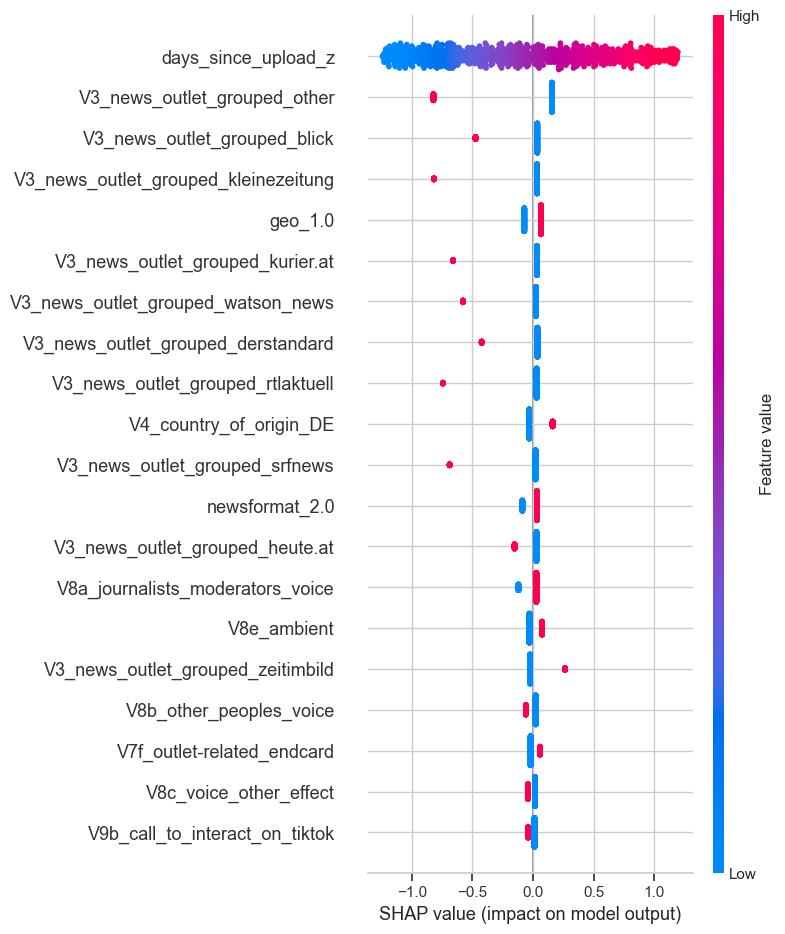

In [16]:
# -------------------------
# 7) SHAP for linear model
#    For linear model use LinearExplainer (fast) or KernelExplainer.
#    Linear model SHAP is usually reliable and interpretable.
# -------------------------
explainer_lin = shap.Explainer(lr, X_train, feature_names=X_train.columns)
shap_vals_lin = explainer_lin(X_test)
# Summary plot (global feature importance)
shap.summary_plot(shap_vals_lin, X_test)
plt.tight_layout()
plt.savefig("shap_summary_linear.png", dpi=200)
plt.close()

In [14]:
# -------------------------
# 8) Random Forest baseline
# -------------------------
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)
print("\nRandom Forest baseline:")
print("Train R²:", r2_score(y_train, y_train_rf))
print("Test R²:", r2_score(y_test, y_test_rf))


Random Forest baseline:
Train R²: 0.9751982105381514
Test R²: 0.8421414358515726


In [17]:
# -------------------------
# 9) Hyperparameter tuning: RandomizedSearchCV for RandomForest
#     IMPORTANT: max_features values must be valid: int, float (0,1], 'sqrt', 'log2', or None
# -------------------------

X_train_shap = X_train.copy()
X_test_shap = X_test.copy()

param_dist = {
    'n_estimators': [200, 500, 800],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]  # 'auto' is invalid for Regressor in newer sklearn
}

rf_base = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score=np.nan
)

rf_random.fit(X_train, y_train)
print("\nBest RF params:", rf_random.best_params_)

# Evaluate tuned model
best_rf = rf_random.best_estimator_
y_train_best = best_rf.predict(X_train)
y_test_best = best_rf.predict(X_test)
print("Tuned RF Train R²:", r2_score(y_train, y_train_best))
print("Tuned RF Test R²:", r2_score(y_test, y_test_best))

# SHAP on tuned RF (same approach as above)
try:
    explainer_best_rf = shap.Explainer(best_rf, X_train_shap, feature_perturbation="interventional")
    shap_vals_best = explainer_best_rf(X_test_shap)
    shap.summary_plot(shap_vals_best, X_test_shap, show=False)
    plt.tight_layout()
    plt.savefig("shap_summary_rf_tuned.png", dpi=200)
    plt.close()
except Exception as e:
    print("SHAP tuned RF failed; trying fallback. Error:", e)
    explainer_best_rf = shap.Explainer(best_rf, X_train_shap)
    shap_vals_best = explainer_best_rf(X_test_shap, check_additivity=False)
    shap.summary_plot(shap_vals_best, X_test_shap, show=False)
    plt.tight_layout()
    plt.savefig("shap_summary_rf_tuned_fallback.png", dpi=200)
    plt.close()

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best RF params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 20}
Tuned RF Train R²: 0.899536593531303
Tuned RF Test R²: 0.8482322775528532


100%|===================| 1159/1161 [01:01<00:00]        

SHAP tuned RF failed; trying fallback. Error: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.912764, while the model output was 0.931979. If this difference is acceptable you can set check_additivity=False to disable this check.


 99%|===================| 1144/1161 [00:55<00:00]        